In [1]:
import pandas as pd

In [82]:
df=pd.read_csv("train_age_dataset.csv")

In [3]:
df.shape

(488877, 27)

In [4]:
df.head(100)

,Unnamed: 0,userId,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,...,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group
0,265153,48958844,2,1,0.000,0.0,0.0,0,0.0,0.0,...,0.200000,0.0,0.041667,0.025000,0.000000,0.000000,0.175000,0.033333,0.000000,1
1,405231,51100441,2,2,0.000,0.0,0.0,0,0.0,0.0,...,0.093220,0.0,0.012712,0.018644,0.000000,0.084746,0.000000,0.033898,82.500000,2
2,57867,6887426,2,1,0.000,0.0,0.0,0,0.0,0.0,...,0.002786,0.0,0.000000,0.000557,0.000000,0.002786,0.000000,0.000000,0.000000,1
3,272618,50742404,2,1,0.000,0.0,0.0,0,0.0,0.0,...,0.008403,0.0,0.000000,0.001681,0.000000,0.000000,0.000000,0.008403,0.000000,1
4,251123,45589200,2,2,0.000,0.0,0.0,0,0.0,0.0,...,0.204918,0.0,0.000000,0.049180,0.000000,0.008197,0.057377,0.180328,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,75528,46523944,2,2,0.000,0.0,0.0,0,0.0,0.0,...,0.041322,0.0,0.000000,0.004959,0.000000,0.024793,0.000000,0.000000,0.000000,1
96,510596,2467734,2,1,0.000,0.0,0.0,0,0.0,0.0,...,0.011928,0.0,0.001988,0.002386,0.011928,0.001988,0.000000,0.001988,197.500000,1
97,538027,37369460,2,2,0.024,0.0,0.0,0,0.0,0.0,...,0.400000,0.0,0.252000,0.000000,0.000000,0.504000,0.000000,0.000000,190.428571,3
98,305621,57282115,2,2,0.000,0.0,0.0,0,0.0,0.0,...,0.390476,0.0,0.000000,0.097143,0.000000,0.085714,0.400000,0.000000,0.000000,1


In [4]:
from catboost import CatBoostClassifier
from xgboost import plot_importance, XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [83]:
x_train,x_test,y_train,y_test = train_test_split(df[df.columns[:-1]],df[df.columns[-1]], test_size = 0.2, random_state=2020)
x_train,x_test,y_train,y_test = x_train.reset_index(drop = True),x_test.reset_index(drop = True),y_train.reset_index(drop = True),y_test.reset_index(drop = True)

In [6]:
c = x_train.astype(bool).sum(axis=0)
d = x_test.astype(bool).sum(axis=0)
c

Unnamed: 0                         391100
userId                             391101
tier                               391101
gender                             391101
following_rate                     142468
followers_avg_age                   65867
following_avg_age                   65867
max_repetitive_punc                 55119
num_of_hashtags_per_action            883
emoji_count_per_action               3535
punctuations_per_action             21247
number_of_words_per_action         193911
avgCompletion                      391101
avgTimeSpent                       391101
avgDuration                        391101
avgComments                         35263
creations                          192418
content_views                      391101
num_of_comments                     35263
weekends_trails_watched_per_day    206998
weekdays_trails_watched_per_day    320931
slot1_trails_watched_per_day        71115
slot2_trails_watched_per_day       222821
slot3_trails_watched_per_day      

In [81]:
to_drop = ['num_of_hashtags_per_action', 'emoji_count_per_action']

#to_drop = []
#for feature in c.index:
#    if c[feature]<100000:
#        to_drop+=[feature]
#to_drop += ['followers_avg_age', 'following_avg_age', 'max_repetitive_punc', 'punctuations_per_action', 'avgComments', 'num_of_comments', 'slot1_trails_watched_per_day']
to_drop = list(set(to_drop))
to_drop

['emoji_count_per_action', 'num_of_hashtags_per_action']

In [84]:
def impute_train(feature):
    global x_train
    '''
    data = pd.concat([x_train[feature],y_train], axis = 1)
    data = data[data[feature]!=0]
    class_avgs = []
    for i in range(4):
        values = list(data[data['age_group'] == i+1][feature].values)
        class_avgs += [sum(values)/len(values)]
    indices = x_train[x_train[feature] == 0].index
    for index in indices:
        x_train.at[index, feature] = class_avgs[y_train.at[index] - 1]
    '''
    data = x_train[x_train[feature]!=0][feature].values
    avg = sum(data)/len(data)
    indices = x_train[x_train[feature] == 0].index
    for index in indices:
        x_train.at[index, feature] = avg
        
total_features = list(set(x_train.columns) - set(to_drop))
for feature in total_features:
    if c[feature]<len(x_train):
        impute_train(feature)
clean_x_train = x_train.copy()

In [6]:
print(x_train.shape)
print(y_train.shape)
x_train.tail()

(391101, 24)
(391101,)


,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,...,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2
391096,2,1,0.001748,0.000000,0.000000,0,0.0,0.0,0.0,0.250000,...,0.001748,0.003497,0.0,0.002622,0.000000,0.000000,0.005245,0.000000,0.000000,252.111111
391097,2,1,0.008696,0.000000,0.000000,0,0.0,0.0,0.0,0.000000,...,0.000000,0.208696,0.0,0.000000,0.038261,0.000000,0.191304,0.000000,0.000000,0.000000
391098,2,1,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.000000,...,0.000000,0.009709,0.0,0.004854,0.000000,0.000000,0.000000,0.000000,0.009709,0.000000
391099,2,1,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.000000,...,0.000000,0.039683,0.0,0.023810,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000
391100,1,1,1.105691,1.964706,2.146341,0,0.0,0.0,0.0,0.391813,...,0.560976,2.211382,0.0,0.369919,0.692683,0.284553,1.211382,1.455285,1.252033,185.402640


<AxesSubplot:>

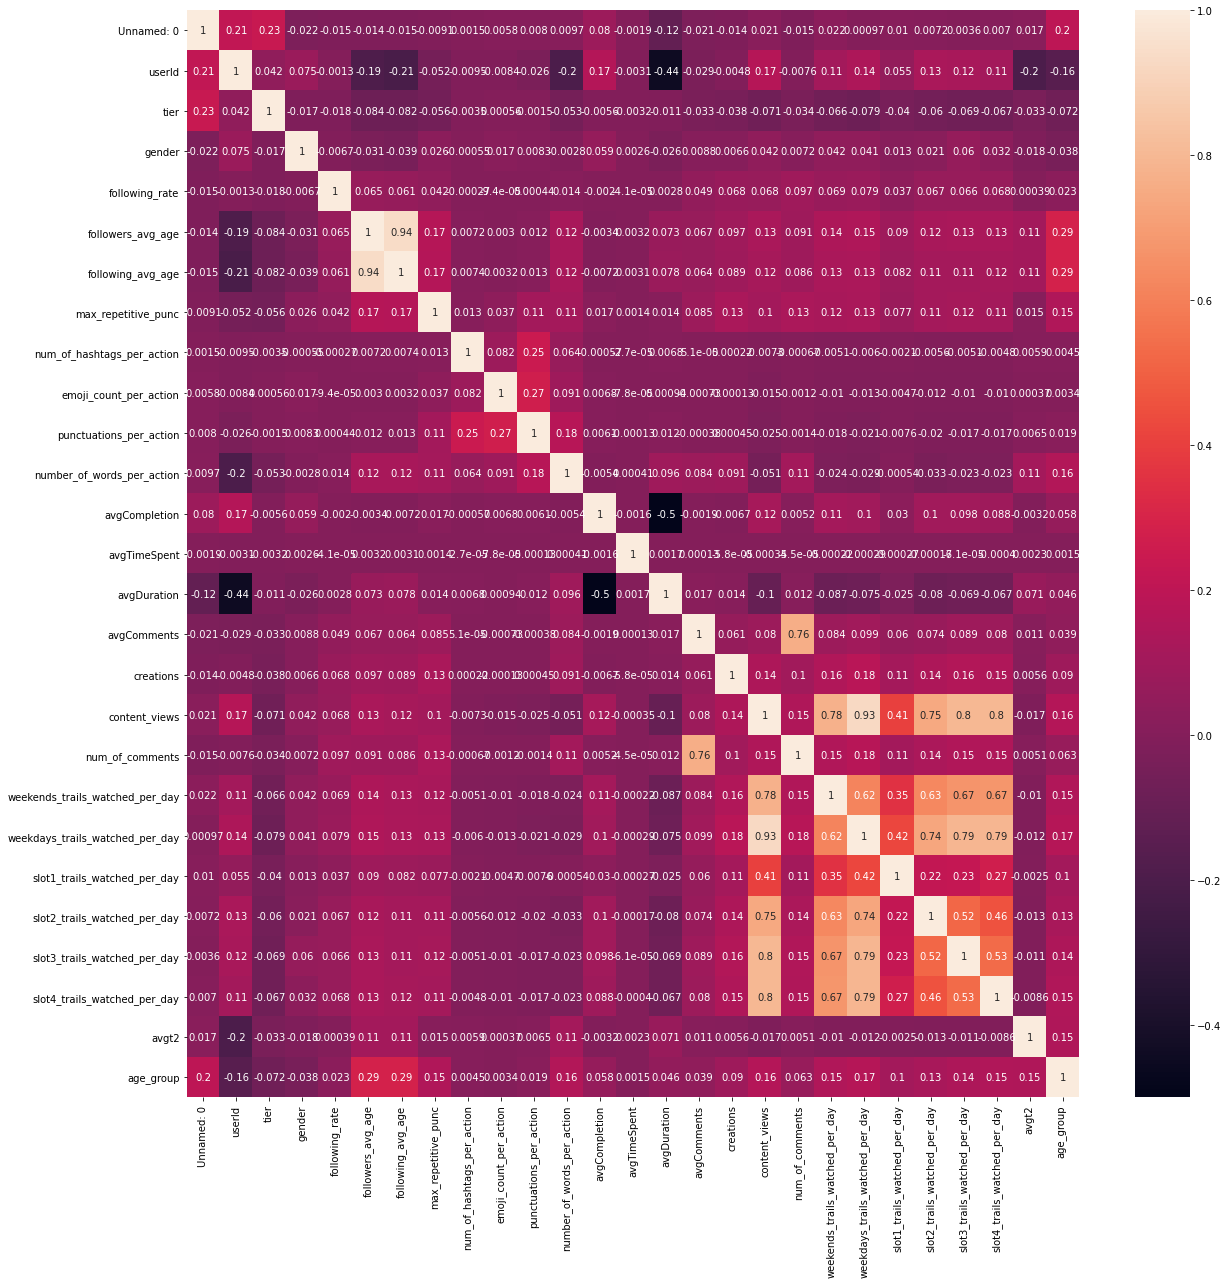

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt
corr=df[df.columns].corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot = True)


In [85]:
to_drop += ['avgComments']
to_drop = list(set(to_drop))
features=['slot2_trails_watched_per_day','weekdays_trails_watched_per_day','weekends_trails_watched_per_day','slot4_trails_watched_per_day','slot3_trails_watched_per_day','content_views']
x = x_train[features]
pca=PCA(n_components=2)
pca_obj=pca.fit(x)
x=pca_obj.transform(x)
len(x)

391101

In [86]:

df2=pd.DataFrame(x)
print(df2.shape)
x_train.drop(features + to_drop, axis=1,inplace=True)
print(x_train.shape)

data=pd.concat([x_train,df2],axis=1)

print(data.shape)
data.tail()

(391101, 2)
(391101, 17)
(391101, 19)


,Unnamed: 0,userId,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,creations,num_of_comments,slot1_trails_watched_per_day,avgt2,0,1
391096,490003,1519957,2,1,0.001748,2.064051,2.393581,5,0.236358,0.250000,0.322285,17.333333,146.616500,0.001748,0.022272,0.181052,252.111111,-0.399288,0.132882
391097,285872,53557206,2,1,0.008696,2.064051,2.393581,5,0.236358,0.361186,0.198379,3.181818,29.011524,0.034629,0.022272,0.181052,338.071249,-0.170248,0.039149
391098,310640,58102117,2,1,0.224380,2.064051,2.393581,5,0.236358,0.361186,0.226586,3.000000,13.240000,0.034629,0.022272,0.181052,338.071249,-0.422941,-0.184255
391099,202696,36324730,2,1,0.224380,2.064051,2.393581,5,0.236358,0.361186,0.342559,23.333333,74.428200,0.034629,0.022272,0.181052,338.071249,-0.370013,0.107735
391100,53258,43887229,1,1,1.105691,1.964706,2.146341,5,0.236358,0.391813,0.208101,9.029014,123.237598,0.560976,0.022272,0.284553,185.402640,2.579933,-0.184190


In [87]:
#model3 = RandomForestClassifier(n_jobs = -1, max_features = "log2", n_estimators = 500)
model3 = CatBoostClassifier(iterations=500,learning_rate=0.8,loss_function = 'MultiClass')
model2 = XGBClassifier(n_estimators=700,objective="multi:softmax")
#model = AdaBoostClassifier(n_estimators=10000, random_state=0)
model1 = LGBMClassifier(n_estimators=500, objective='multiclassova')

model3.fit(data, y_train)
#model1.fit(data, y_train)
model2.fit(data, y_train)


0:	learn: 0.7187919	total: 106ms	remaining: 53.1s
1:	learn: 0.6228414	total: 212ms	remaining: 52.8s
2:	learn: 0.5878756	total: 314ms	remaining: 52s
3:	learn: 0.5605799	total: 423ms	remaining: 52.4s
4:	learn: 0.5496494	total: 517ms	remaining: 51.2s
5:	learn: 0.5437645	total: 616ms	remaining: 50.7s
6:	learn: 0.5328039	total: 718ms	remaining: 50.6s
7:	learn: 0.5284384	total: 819ms	remaining: 50.3s
8:	learn: 0.5214720	total: 919ms	remaining: 50.1s
9:	learn: 0.5189824	total: 1.01s	remaining: 49.7s
10:	learn: 0.5154916	total: 1.12s	remaining: 49.7s
11:	learn: 0.5114458	total: 1.22s	remaining: 49.7s
12:	learn: 0.5059998	total: 1.32s	remaining: 49.5s
13:	learn: 0.5046997	total: 1.42s	remaining: 49.3s
14:	learn: 0.5035289	total: 1.51s	remaining: 48.7s
15:	learn: 0.5020890	total: 1.6s	remaining: 48.5s
16:	learn: 0.5007705	total: 1.7s	remaining: 48.2s
17:	learn: 0.4988949	total: 1.8s	remaining: 48.2s
18:	learn: 0.4983388	total: 1.89s	remaining: 47.8s
19:	learn: 0.4973180	total: 1.99s	remaining: 4

163:	learn: 0.4547933	total: 15.6s	remaining: 31.9s
164:	learn: 0.4546467	total: 15.7s	remaining: 31.8s
165:	learn: 0.4544723	total: 15.8s	remaining: 31.7s
166:	learn: 0.4543484	total: 15.8s	remaining: 31.6s
167:	learn: 0.4541736	total: 15.9s	remaining: 31.5s
168:	learn: 0.4536967	total: 16s	remaining: 31.4s
169:	learn: 0.4535701	total: 16.1s	remaining: 31.3s
170:	learn: 0.4534257	total: 16.2s	remaining: 31.2s
171:	learn: 0.4532596	total: 16.3s	remaining: 31.1s
172:	learn: 0.4531472	total: 16.4s	remaining: 31s
173:	learn: 0.4530282	total: 16.5s	remaining: 30.9s
174:	learn: 0.4528907	total: 16.6s	remaining: 30.8s
175:	learn: 0.4526979	total: 16.7s	remaining: 30.7s
176:	learn: 0.4525716	total: 16.8s	remaining: 30.6s
177:	learn: 0.4524862	total: 16.9s	remaining: 30.5s
178:	learn: 0.4523768	total: 17s	remaining: 30.4s
179:	learn: 0.4523027	total: 17.1s	remaining: 30.3s
180:	learn: 0.4520955	total: 17.1s	remaining: 30.2s
181:	learn: 0.4519726	total: 17.2s	remaining: 30.1s
182:	learn: 0.4518

322:	learn: 0.4329723	total: 30.6s	remaining: 16.8s
323:	learn: 0.4323902	total: 30.7s	remaining: 16.7s
324:	learn: 0.4322722	total: 30.8s	remaining: 16.6s
325:	learn: 0.4321155	total: 30.9s	remaining: 16.5s
326:	learn: 0.4319413	total: 31s	remaining: 16.4s
327:	learn: 0.4318259	total: 31.2s	remaining: 16.3s
328:	learn: 0.4317403	total: 31.3s	remaining: 16.2s
329:	learn: 0.4315976	total: 31.4s	remaining: 16.2s
330:	learn: 0.4314612	total: 31.5s	remaining: 16.1s
331:	learn: 0.4313202	total: 31.6s	remaining: 16s
332:	learn: 0.4312285	total: 31.7s	remaining: 15.9s
333:	learn: 0.4311546	total: 31.8s	remaining: 15.8s
334:	learn: 0.4310056	total: 31.9s	remaining: 15.7s
335:	learn: 0.4308364	total: 32s	remaining: 15.6s
336:	learn: 0.4307203	total: 32.1s	remaining: 15.5s
337:	learn: 0.4305795	total: 32.2s	remaining: 15.4s
338:	learn: 0.4304443	total: 32.3s	remaining: 15.3s
339:	learn: 0.4302916	total: 32.4s	remaining: 15.2s
340:	learn: 0.4301466	total: 32.5s	remaining: 15.1s
341:	learn: 0.4300

481:	learn: 0.4133132	total: 46s	remaining: 1.72s
482:	learn: 0.4132299	total: 46.1s	remaining: 1.62s
483:	learn: 0.4130862	total: 46.2s	remaining: 1.53s
484:	learn: 0.4130171	total: 46.3s	remaining: 1.43s
485:	learn: 0.4128648	total: 46.4s	remaining: 1.33s
486:	learn: 0.4127095	total: 46.5s	remaining: 1.24s
487:	learn: 0.4125620	total: 46.6s	remaining: 1.14s
488:	learn: 0.4124492	total: 46.7s	remaining: 1.05s
489:	learn: 0.4123650	total: 46.7s	remaining: 954ms
490:	learn: 0.4122913	total: 46.8s	remaining: 859ms
491:	learn: 0.4121507	total: 46.9s	remaining: 763ms
492:	learn: 0.4120455	total: 47s	remaining: 668ms
493:	learn: 0.4119111	total: 47.2s	remaining: 573ms
494:	learn: 0.4117867	total: 47.2s	remaining: 477ms
495:	learn: 0.4116547	total: 47.4s	remaining: 382ms
496:	learn: 0.4115875	total: 47.5s	remaining: 287ms
497:	learn: 0.4114585	total: 47.6s	remaining: 191ms
498:	learn: 0.4112925	total: 47.7s	remaining: 95.5ms
499:	learn: 0.4111431	total: 47.8s	remaining: 0us


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=700, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [88]:
model4 = KNeighborsClassifier(n_neighbors = 13, weights = 'distance', n_jobs = -1)
model4.fit(data,y_train)


KNeighborsClassifier(n_jobs=-1, n_neighbors=13, weights='distance')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

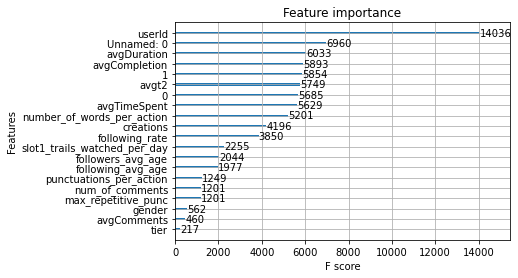

In [138]:
plot_importance(model2)

## Test model



In [90]:
def impute_test(feature):
    global x_test
    vals = list(clean_x_train[feature].values)
    avg = sum(vals)/len(vals)
    indices = list(x_test[x_test[feature]==0].index)
    for i in indices:
        x_test.at[i,feature] = avg
for feature in list(set(x_test.columns)-set(to_drop)):
    if d[feature]<len(x_test):
        impute_test(feature)


In [91]:
y=x_test[features]
y=pca_obj.transform(y)
df3=pd.DataFrame(y)
x_test.drop(features + to_drop, axis=1, inplace = True)
x_test=pd.concat([x_test,df3],axis=1)

In [121]:
from sklearn.metrics import f1_score
import numpy as np
y_pred = list(np.argmax(np.array((0.08*model3.predict_proba(x_test) +0.22*model4.predict_proba(x_test) + 0.85*model2.predict_proba(x_test))),axis = 1)+1)
f1_score(y_test,y_pred, average = 'weighted')

0.8075715004895355

<AxesSubplot:>

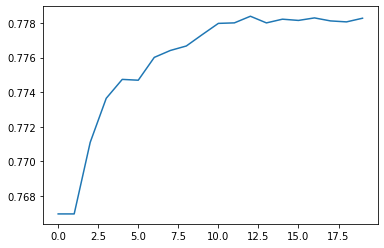

In [23]:
scores = []
for model in models:
    y_pred = list(np.argmax(np.array((model.predict_proba(x_test))),axis = 1)+1)
    scores+=[f1_score(y_test,y_pred, average = 'weighted')]
sns.lineplot(x=range(20), y = scores)

## Make final pred

In [122]:
test_data = pd.read_csv("test_age_dataset.csv")
e = test_data.astype(bool).sum(axis=0)

In [123]:
def impute_test_fin(feature):
    global test_data
    vals = list(clean_x_train[feature].values)
    avg = sum(vals)/len(vals)
    indices = list(test_data[test_data[feature]==0].index)
    for i in indices:
        test_data.at[i,feature] = avg

for feature in list(set(test_data.columns)-set(to_drop)):
    if e[feature]<len(test_data):
        impute_test_fin(feature)

In [124]:
a = test_data[features]
df = pd.DataFrame(pca_obj.transform(a))
#test_data.drop(features + ["userId", "Unnamed: 0"] + to_drop, axis=1, inplace = True)
test_data.drop(features + to_drop, axis=1, inplace = True)
test=pd.concat([test_data,df],axis=1)


In [142]:
pred = list(np.argmax(np.array(0.02*model3.predict_proba(test) +0.18*model4.predict_proba(test) + 0.85*model2.predict_proba(test) ),axis = 1)+1)
pred = pd.DataFrame(data=pred, index = None, columns = ["prediction"])
pred.to_csv("pred.csv", index = False)